# Fundamentals of Data Science Final Project

### Foootball Match Result Prediction
Submitted by,<br>
<pre>    1. Syed Habibul Bashar    Matricola: 2102742 bashar.2102742@studenti.uniroma1.it <br>
    2. Time Ragno             Matricola: 2116901 ragno.2116901@studenti.uniroma1.it<br>
    3. Francesco Proietti     Matricola: 1873188 proietti.1873188@studenti.uniroma1.it<br>
    4. Aysegul Sine Ozgenkan  Matricola: 2108754 ozgenkan.2108754@studenti.uniroma1.it<br>


## Introduction

Football is a complex and unpredictable sport with a lot of moving variables. This is why we thought as a team give it a shot at trying to make predictions! We tried out a few machine learning techniques to try and make our predictions as accurate as possible. The first one we tried is a fairly simple from of classifier. Stochastic Gradient Descent (SGD) Classifier is a simple yet effective machine learning algorithm commonly used for classification tasks. We then tried out hand in somthing much more complex and an overall more powerful algorithm known as RandomForest.

### A. Objective of the Project

The main goal of our project is to understand how machine learning can help predict football match results. We began with the straightforward SGD Classifier and later transitioned to the Random Forest algorithm to see how well it can handle the complexity of football data and improve our predictions.

### B. Importance of Predicting Football Match Results

Putting aside the fun and joy aspect of this project; it has practical uses for team managers, analysts, and fans. Our project aims to contribute to the world of sports analytics by showing how advanced machine learning techniques, like the Random Forest algorithm, can enhance our ability to predict football match results.

### C. Brief Overview of Repositories Used as References

Three important repositories guided our project [Repository 1](https://www.kaggle.com/code/airback/match-outcome-prediction-in-football), [Repository 2](https://www.kaggle.com/code/sslp23/predicting-fifa-2022-world-cup-with-ml), [Repository 3](https://github.com/motapinto/football-classification-predications/blob/master/src/Supervised%20Learning%20Models.ipynb) providing insights into using differnent machinelearning techniques.

### Data Collection
We collected our data for the project from [kaggle](https://www.kaggle.com/datasets/hugomathien/soccer) .

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from collections import defaultdict
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.model_selection import cross_val_score
from yellowbrick.classifier import ROCAUC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# We import the tables from the CSV files.
# NOTE : the PL_matches file was created separately by selecting only the Premier League (PL) matches

df_pl = pd.read_csv("PL_matches.csv")
df_teams_attributes = pd.read_csv("Team_attr.csv")
df_teams = pd.read_csv("Team_.csv")


In [ ]:
df_pl.head()

Unnamed: 0    id  country_id  league_id     season                 date  \
0        1728  1729        1729       1729  2008/2009  2008-08-17 00:00:00   
1        1729  1730        1729       1729  2008/2009  2008-08-16 00:00:00   
2        1730  1731        1729       1729  2008/2009  2008-08-16 00:00:00   
3        1731  1732        1729       1729  2008/2009  2008-08-16 00:00:00   
4        1732  1733        1729       1729  2008/2009  2008-08-17 00:00:00   

   home_team_api_id  away_team_api_id  home_team_goal  away_team_goal  
0             10260             10261               1               1  
1              9825              8659               1               0  
2              8472              8650               0               1  
3              8654              8528               2               1  
4             10252              8456               4               2

# Feature Enginerring

The first part for any kind of project like this is to create relevant variables for our specific needs. We also have to create the actual target variable (result here) based on the other variables.
Something to note is that there were other variables for every match in the season (shoton, number of yellow/red cards...) but they were hard to read. We chose that our problem was already complex enough to not use them.

In [ ]:
# We only have the goals scored by each team but we're only interested in predicting the result for our study
df_pl['result'] = df_pl.apply(lambda row: 'Home Win' if row['home_team_goal'] > row['away_team_goal'] else 'Away Win' if row['home_team_goal'] < row["away_team_goal"] else 'Draw', axis=1)

# Create a "goal_difference" column to see the magnitude of the win
df_pl['goal_difference'] = df_pl['home_team_goal'] - df_pl['away_team_goal']

# Substitue the team_api_id with the Team's real name
df_pl = df_pl.replace({"home_team_api_id": df_teams.set_index('team_api_id')['team_long_name']})
df_pl = df_pl.replace({"away_team_api_id": df_teams.set_index('team_api_id')['team_long_name']})

# We drop the columns we don't need anymore (as we know that we only focus on PL teams and matches)
# We also decided to drop the goals columns as they would be redundant with the other columns we created
# This decision can be discussed after the fact
df_pl.drop(['id', 'country_id', 'league_id', 'home_team_goal', 'away_team_goal'], axis=1, inplace=True)


In [ ]:
df_pl

Unnamed: 0     season                 date      home_team_api_id  \
0           1728  2008/2009  2008-08-17 00:00:00     Manchester United   
1           1729  2008/2009  2008-08-16 00:00:00               Arsenal   
2           1730  2008/2009  2008-08-16 00:00:00            Sunderland   
3           1731  2008/2009  2008-08-16 00:00:00       West Ham United   
4           1732  2008/2009  2008-08-17 00:00:00           Aston Villa   
...          ...        ...                  ...                   ...   
3035        4763  2015/2016  2015-10-17 00:00:00           Southampton   
3036        4764  2015/2016  2015-10-19 00:00:00          Swansea City   
3037        4765  2015/2016  2015-10-17 00:00:00     Tottenham Hotspur   
3038        4766  2015/2016  2015-10-17 00:00:00               Watford   
3039        4767  2015/2016  2015-10-17 00:00:00  West Bromwich Albion   

          away_team_api_id    result  goal_difference  
0         Newcastle United      Draw                0  
1     West Bromwich Albion  Home Win                1  
2                Liverpool  Away Win               -1  
3           Wigan Athletic  Home Win                1  
4          Manchester City  Home Win                2  
...                    ...       ...              ...  
3035        Leicester City      Draw                0  
3036            Stoke City  Away Win               -1  
3037             Liverpool      Draw                0  
3038               Arsenal  Away Win               -3  
3039            Sunderland  Home Win                1  

[3040 rows x 7 columns]

Our model will need to decide on a match's outcome based on other variables. In real life, we can often try to predict the same thing. Our decisions are often heavily influenced by the teams' recent performances and their overall ratings. This is what we want to capture here with the new variables we create.

We have to note that real life decisions are often influenced by unquantifiable (or hard to quantify) variables (like the bias towards teams you support, or the strength of a given team in a given league/event) that we can't account for here.

In [ ]:
# For each season, order the matches played by date
# This is done to facilitate the other computations we will do later
df_pl = df_pl.sort_values(by=['season', 'date'])


def calculate_points(result, home_away: str):
    '''
    This is a helper function used later to compute the total points of each team at
    the end of each match.
    '''
    if result == f'{home_away} Win':
        return 3
    elif result == 'Draw':
        return 1
    else:
        return 0


dict_pts = {}

# This is used to create the columns and default their values to ints
df_pl['pts_home'] = 0
df_pl['pts_away'] = 0


# We oterate through each season and each match to compute the points and increment the number
# of points for each team for the given season. We use dictionaries for fast lookup times.
for season in df_pl['season'].unique():
    df_pl_season = df_pl[df_pl['season'] == season]
    dict_pts[season] = defaultdict(int)
    for index, row in df_pl_season.iterrows():
        home = row['home_team_api_id']; away = row['away_team_api_id']
        dict_pts[season][home] += calculate_points(row['result'], 'Home')
        dict_pts[season][away] += calculate_points(row['result'], 'Away')
        df_pl.at[index, 'pts_home'] = dict_pts[season][home]; df_pl.at[index, 'pts_away'] = dict_pts[season][away]





# We add a "form" column to the dataframe that represents the number of points earned by each team in the last 5 games
# We also add a "number of draws" columns for each team. Ideally, a team with a high number of draws will be more likely to draw again
# We choose 5 as the number of gales we have to look past to.
df_pl['n_draws_home'] = 0
df_pl['n_draws_away'] = 0

df_pl['form_home'] = 0
df_pl['form_away'] = 0
for season in df_pl['season'].unique():
    for team in df_pl['home_team_api_id'].unique():
        df_pl_season = df_pl[(df_pl['season'] == season) & ((df_pl['home_team_api_id'] == team) | (df_pl['away_team_api_id'] == team))]

        # Reset index (keeps the old ones in a column called 'index')
        df_pl_season = df_pl_season.reset_index()
        for index, row in df_pl_season.iterrows():

            home_away = 'home' if row['home_team_api_id'] == team else 'away'
            pts_now = df_pl_season.at[index, f'pts_{home_away}']
            old_index = df_pl_season.at[index, 'index']
            # We choose to believe that a team's "form" carries on even after a season's end, this somewhat echoes the real life sentiment
            # (For example: even at the start of a new season, we at first believe the the best teams will stay the same like Man. City in the PL to cite one example)
            if index < 5:
                df_pl.at[old_index, f'form_{home_away}'] = pts_now

                # We choose to reset the number of draws a team has at the start of each season
                # (as the team can look incredibly different between the end of a season and the start of the next)
                if index == 0:
                    df_pl.at[old_index, 'n_draws_home'] = 0
                    df_pl.at[old_index, 'n_draws_away'] = 0
            else:
                # The main problem is that the away team for our given match could've been be the home team 5 matches ago (and vice versa)
                # We have to account for this here

                pts_then = df_pl_season.at[index-5, 'pts_home'] if df_pl_season.at[index-5, 'home_team_api_id'] == team else df_pl_season.at[index-5, 'pts_away']
                df_pl.at[old_index, f'form_{home_away}'] = pts_now - pts_then
                for i in range(1, min(index, 5) + 1):
                    home_away_then = 'home' if df_pl_season.at[index-i, 'home_team_api_id'] == team else 'away'
                    draw_then = df_pl_season.at[index-i, 'result'] == 'Draw'
                    df_pl.at[old_index, f'n_draws_{home_away}'] += 1 if draw_then else 0




# We add the head-to-head stats between the two teams to the dataframe using the match results.
# We consider the last 5 games played between the two teams.
# Only one column is needed as the other one is the opposite of the first one


df_pl['h2h_home'] = 0
df_pl['h2h_away'] = 0
for team1, team2 in combinations(df_pl['home_team_api_id'].unique(), 2):
    df_pl_h2h = df_pl[((df_pl['home_team_api_id'] == team1) & (df_pl['away_team_api_id'] == team2)) | ((df_pl['home_team_api_id'] == team2) & (df_pl['away_team_api_id'] == team1))]
    df_pl_h2h = df_pl_h2h.reset_index()
    for index, row in df_pl_h2h.iterrows():
        home_away_team1 = 'home' if row['home_team_api_id'] == team1 else 'away'
        home_away_team2 = 'home' if row['home_team_api_id'] == team2 else 'away'
        old_index = df_pl_h2h.at[index, 'index']
        if index == 0:
            df_pl.at[old_index, f'h2h_home'] = 0
            df_pl.at[old_index, f'h2h_away'] = 0
        else:
            for i in range(1, min(index, 5) + 1):
                home_away_i_team1 = 'Home' if df_pl_h2h.at[index - i, 'home_team_api_id'] == team1 else 'Away'
                home_away_i_team2 = 'Home' if df_pl_h2h.at[index - i, 'home_team_api_id'] == team2 else 'Away'
                df_pl.at[old_index, f'h2h_{home_away_team1}'] += calculate_points(df_pl_h2h.at[index - i, 'result'], home_away_i_team1)
                df_pl.at[old_index, f'h2h_{home_away_team2}'] += calculate_points(df_pl_h2h.at[index - i, 'result'], home_away_i_team2)


#df_pl.dropna(inplace=True) #There are no null values in the dataset


Now, we have to take into account the teams' attributes for each time. This is copied for the away and home teams for each team for each season. This is a very computationally expensive endeavor that is justified by the relatively small number of seasons in the dataset (2008/2009 - 2015/2016).
At first, we visualise the team attributes dataset with the "long name" of each team (coming from the teams dataframe).

In [ ]:
# We consider only the attribute variables (and not their class as it would be redundant) for each team.
# This was extracted from the FIFA games to our dataset, as such, they all have the same range of values (1 - 100)

df_teams_attributes_reduced = df_teams_attributes[['date', 'team_fifa_api_id', 'team_api_id', 'buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 'defencePressure', 'defenceAggression', 'defenceTeamWidth']]
df_teams_attributes_reduced = df_teams_attributes_reduced.replace({"team_api_id": df_teams.set_index('team_api_id')['team_long_name']})


df_teams_attributes_reduced

date  team_fifa_api_id       team_api_id  \
0     2010-02-22 00:00:00               434          FC Aarau   
1     2014-09-19 00:00:00               434          FC Aarau   
2     2015-09-10 00:00:00               434          FC Aarau   
3     2010-02-22 00:00:00                77          Aberdeen   
4     2011-02-22 00:00:00                77          Aberdeen   
...                   ...               ...               ...   
1453  2011-02-22 00:00:00             15005  SV Zulte-Waregem   
1454  2012-02-22 00:00:00             15005  SV Zulte-Waregem   
1455  2013-09-20 00:00:00             15005  SV Zulte-Waregem   
1456  2014-09-19 00:00:00             15005  SV Zulte-Waregem   
1457  2015-09-10 00:00:00             15005  SV Zulte-Waregem   

      buildUpPlaySpeed  buildUpPlayDribbling  buildUpPlayPassing  \
0                   60                   NaN                  50   
1                   52                  48.0                  56   
2                   47                  41.0                  54   
3                   70                   NaN                  70   
4                   47                   NaN                  52   
...                ...                   ...                 ...   
1453                52                   NaN                  52   
1454                54                   NaN                  51   
1455                54                   NaN                  51   
1456                54                  42.0                  51   
1457                54                  42.0                  51   

      chanceCreationPassing  chanceCreationCrossing  chanceCreationShooting  \
0                        60                      65                      55   
1                        54                      63                      64   
2                        54                      63                      64   
3                        70                      70                      70   
4                        53                      48                      52   
...                     ...                     ...                     ...   
1453                     52                      48                      53   
1454                     47                      52                      50   
1455                     47                      52                      32   
1456                     47                      52                      32   
1457                     47                      52                      32   

      defencePressure  defenceAggression  defenceTeamWidth  
0                  50                 55                45  
1                  47                 44                54  
2                  47                 44                54  
3                  60                 70                70  
4                  47                 47                52  
...               ...                ...               ...  
1453               46                 48                53  
1454               44                 55                53  
1455               44                 58                37  
1456               44                 58                37  
1457               44                 58                37  

[1458 rows x 12 columns]

Finally, we actually merge the two datasets to get the teams' attributes for each match.

In [ ]:
# Convert the 'date' columns to datetime (to ensure compability when merging)
df_pl_ratio = df_pl.copy()
df_pl_ratio['date'] = pd.to_datetime(df_pl_ratio['date'])
df_teams_attributes_reduced['date'] = pd.to_datetime(df_teams_attributes_reduced['date'])

# Sort the dataframes by date
df_pl_ratio = df_pl_ratio.sort_values('date')
df_teams_attributes_reduced = df_teams_attributes_reduced.sort_values('date')

# We apply a little trick, first, we group by team. Then, we resample the date values to cover every day (with the same value until it is updated using ffill and first)
# This allows us to merge the datasets (as the update day in FIFA may not even correspond to a match day)
df_teams_attributes_daily = df_teams_attributes_reduced.groupby('team_api_id').resample('D', on='date').first().ffill()
df_teams_attributes_daily.drop('team_api_id', axis=1, inplace=True)


# Merge the dataframes on the ids and the dates (with left join to keep all the matches and not a single one for every team)
df_pl_home = df_pl_ratio.merge(df_teams_attributes_daily, left_on=['home_team_api_id', 'date'], right_on=['team_api_id', 'date'], how='left')
df_pl_full = df_pl_home.merge(df_teams_attributes_daily, left_on=['away_team_api_id', 'date'], right_on=['team_api_id', 'date'], how='left')
df_pl_full.drop(['team_fifa_api_id_x', 'team_fifa_api_id_y'], axis=1, inplace=True)
df_pl_full.dropna(inplace=True)

df_pl_full

Unnamed: 0     season       date   home_team_api_id  \
644         2311  2009/2010 2010-02-23  Manchester United   
645         2317  2009/2010 2010-02-27   Bolton Wanderers   
646         2316  2009/2010 2010-02-27            Burnley   
647         2315  2009/2010 2010-02-27    Birmingham City   
648         2310  2009/2010 2010-02-27         Stoke City   
...          ...        ...        ...                ...   
2695        4710  2015/2016 2015-08-29            Chelsea   
2696        4709  2015/2016 2015-08-29        Bournemouth   
2697        4711  2015/2016 2015-08-29          Liverpool   
2698        4714  2015/2016 2015-08-30        Southampton   
2699        4716  2015/2016 2015-08-30       Swansea City   

             away_team_api_id    result  goal_difference  pts_home  pts_away  \
644           West Ham United  Home Win                3        60        27   
645   Wolverhampton Wanderers  Home Win                1        26        24   
646                Portsmouth  Away Win               -1        23        19   
647            Wigan Athletic  Home Win                1        40        25   
648                   Arsenal  Away Win               -2        34        58   
...                       ...       ...              ...       ...       ...   
2695           Crystal Palace  Away Win               -1         4         9   
2696           Leicester City      Draw                0         4         8   
2697          West Ham United  Away Win               -3         7         6   
2698             Norwich City  Home Win                3         5         4   
2699        Manchester United  Home Win                1         8         7   

      n_draws_home  ...  defenceTeamWidth_x  buildUpPlaySpeed_y  \
644              1  ...                40.0                58.0   
645              2  ...                35.0                70.0   
646              0  ...                70.0                70.0   
647              1  ...                70.0                70.0   
648              3  ...                35.0                66.0   
...            ...  ...                 ...                 ...   
2695             0  ...                46.0                61.0   
2696             0  ...                62.0                63.0   
2697             0  ...                62.0                72.0   
2698             0  ...                44.0                45.0   
2699             0  ...                54.0                46.0   

      buildUpPlayDribbling_y  buildUpPlayPassing_y  chanceCreationPassing_y  \
644                     32.0                  30.0                     31.0   
645                     49.0                  70.0                     70.0   
646                     33.0                  70.0                     70.0   
647                     52.0                  70.0                     70.0   
648                     61.0                  30.0                     30.0   
...                      ...                   ...                      ...   
2695                    36.0                  68.0                     67.0   
2696                    36.0                  48.0                     47.0   
2697                    39.0                  73.0                     68.0   
2698                    28.0                  64.0                     55.0   
2699                    34.0                  54.0                     49.0   

      chanceCreationCrossing_y  chanceCreationShooting_y  defencePressure_y  \
644                       70.0                      50.0               30.0   
645                       70.0                      70.0               70.0   
646                       70.0                      55.0               40.0   
647                       70.0                      50.0               35.0   
648                       45.0                      35.0               30.0   
...                        ...                       ...                ...   
2695 

In [ ]:
print(df_pl_full.columns)

Index(['Unnamed: 0', 'season', 'date', 'home_team_api_id', 'away_team_api_id',
       'result', 'goal_difference', 'pts_home', 'pts_away', 'n_draws_home',
       'n_draws_away', 'form_home', 'form_away', 'h2h_home', 'h2h_away',
       'buildUpPlaySpeed_x', 'buildUpPlayDribbling_x', 'buildUpPlayPassing_x',
       'chanceCreationPassing_x', 'chanceCreationCrossing_x',
       'chanceCreationShooting_x', 'defencePressure_x', 'defenceAggression_x',
       'defenceTeamWidth_x', 'buildUpPlaySpeed_y', 'buildUpPlayDribbling_y',
       'buildUpPlayPassing_y', 'chanceCreationPassing_y',
       'chanceCreationCrossing_y', 'chanceCreationShooting_y',
       'defencePressure_y', 'defenceAggression_y', 'defenceTeamWidth_y'],
      dtype='object')


Separate Home and Away Data:
Create separate dataframes for home and away matches using the 'x' and 'y' columns.

In [ ]:
home_columns = ['home_team_api_id', 'buildUpPlaySpeed_x', 'buildUpPlayDribbling_x', 'buildUpPlayPassing_x',
                 'chanceCreationPassing_x', 'chanceCreationCrossing_x', 'chanceCreationShooting_x',
                 'defencePressure_x', 'defenceAggression_x', 'defenceTeamWidth_x']
away_columns = ['away_team_api_id', 'buildUpPlaySpeed_y', 'buildUpPlayDribbling_y', 'buildUpPlayPassing_y',
                 'chanceCreationPassing_y', 'chanceCreationCrossing_y', 'chanceCreationShooting_y',
                 'defencePressure_y', 'defenceAggression_y', 'defenceTeamWidth_y']

home_data = df_pl_full[home_columns]
away_data = df_pl_full[away_columns]

Aggregate Data:
Aggregate the data to get average or sum values for each team, depending on your preference.

In [ ]:
unique_teams = home_data['home_team_api_id'].unique()
print(unique_teams)

['Manchester United' 'Bolton Wanderers' 'Burnley' 'Birmingham City'
 'Stoke City' 'Chelsea' 'Sunderland' 'Tottenham Hotspur' 'Liverpool'
 'West Ham United' 'Arsenal' 'Wolverhampton Wanderers' 'Everton'
 'Wigan Athletic' 'Portsmouth' 'Hull City' 'Aston Villa' 'Fulham'
 'Blackburn Rovers' 'Manchester City' 'West Bromwich Albion'
 'Newcastle United' 'Blackpool' 'Queens Park Rangers' 'Swansea City'
 'Norwich City' 'Reading' 'Southampton' 'Crystal Palace' 'Cardiff City'
 'Leicester City' 'Bournemouth' 'Watford']


The PL 2015/2016 Season. <br>
This is there seasons for which we will train our model to predict.

In [ ]:
terget_season_data = df_pl_full[df_pl_full['season'].astype(str).str.contains('2015/2016')]

In [ ]:
terget_season_data

Unnamed: 0     season       date      home_team_api_id  \
2660        4393  2015/2016 2015-08-08     Manchester United   
2661        4392  2015/2016 2015-08-08        Leicester City   
2662        4395  2015/2016 2015-08-08          Norwich City   
2663        4390  2015/2016 2015-08-08               Chelsea   
2664        4389  2015/2016 2015-08-08           Bournemouth   
2665        4391  2015/2016 2015-08-08               Everton   
2666        4388  2015/2016 2015-08-09               Arsenal   
2667        4394  2015/2016 2015-08-09      Newcastle United   
2668        4396  2015/2016 2015-08-09            Stoke City   
2669        4397  2015/2016 2015-08-10  West Bromwich Albion   
2670        4498  2015/2016 2015-08-14           Aston Villa   
2671        4506  2015/2016 2015-08-15               Watford   
2672        4502  2015/2016 2015-08-15           Southampton   
2673        4503  2015/2016 2015-08-15            Sunderland   
2674        4504  2015/2016 2015-08-15          Swansea City   
2675        4505  2015/2016 2015-08-15     Tottenham Hotspur   
2676        4507  2015/2016 2015-08-15       West Ham United   
2677        4501  2015/2016 2015-08-16       Manchester City   
2678        4499  2015/2016 2015-08-16        Crystal Palace   
2679        4500  2015/2016 2015-08-17             Liverpool   
2680        4609  2015/2016 2015-08-22        Crystal Palace   
2681        4611  2015/2016 2015-08-22        Leicester City   
2682        4612  2015/2016 2015-08-22     Manchester United   
2683        4613  2015/2016 2015-08-22          Norwich City   
2684        4614  2015/2016 2015-08-22            Sunderland   
2685        4617  2015/2016 2015-08-22       West Ham United   
2686        4616  2015/2016 2015-08-23  West Bromwich Albion   
2687        4610  2015/2016 2015-08-23               Everton   
2688        4615  2015/2016 2015-08-23               Watford   
2689        4608  2015/2016 2015-08-24               Arsenal   
2690        4717  2015/2016 2015-08-29     Tottenham Hotspur   
2691        4715  2015/2016 2015-08-29            Stoke City   
2692        4713  2015/2016 2015-08-29      Newcastle United   
2693        4712  2015/2016 2015-08-29       Manchester City   
2694        4708  2015/2016 2015-08-29           Aston Villa   
2695        4710  2015/2016 2015-08-29               Chelsea   
2696        4709  2015/2016 2015-08-29           Bournemouth   
2697        4711  2015/2016 2015-08-29             Liverpool   
2698        4714  2015/2016 2015-08-30           Southampton   
2699        4716  2015/2016 2015-08-30          Swansea City   

          away_team_api_id    result  goal_difference  pts_home  pts_away  \
2660     Tottenham Hotspur  Home Win                1         3         0   
2661            Sunderland  Home Win                2         3         0   
2662        Crystal Palace  Away Win               -2         0         3   
2663          Swansea City      Draw                0         1         1   
2664           Aston Villa  Away Win               -1         0         3   
2665               Watford      Draw                0         1         1   
2666       West Ham United  Away Win               -2         0         3   
2667           Southampton      Draw                0         1         1   
2668             Liverpool  Away Win               -1         0         3   
2669       Manchester City  Away Win               -3         0         3   
2670     Manchester United  Away Win               -1         3         6   
2671  West Bromwich Albion      Draw                0         2         1   
2672               Everton  Away Win               -3         1         4   
2673          Norwich City  Away Win               -2         0         3   
2674      Newcastle United  Home Win                2         4         1   
2675            Stoke City      Draw                0         1         1   
2676        Leicester City  Away Win               -1         3         

All of the teams in the Terget season.

In [ ]:
terget_teams = terget_season_data['home_team_api_id'].unique()
print(terget_teams)

['Manchester United' 'Leicester City' 'Norwich City' 'Chelsea'
 'Bournemouth' 'Everton' 'Arsenal' 'Newcastle United' 'Stoke City'
 'West Bromwich Albion' 'Aston Villa' 'Watford' 'Southampton' 'Sunderland'
 'Swansea City' 'Tottenham Hotspur' 'West Ham United' 'Manchester City'
 'Crystal Palace' 'Liverpool']


In [ ]:
prev_season_data = df_pl_full[df_pl_full['season'].astype(str).str.contains('2014/2015')]

Latest stats of a team


In [ ]:
def get_last_team_stats(team_id, date, team_stats):
    # Filter team stats
    all_team_stats_home = team_stats[team_stats['home_team_api_id'] == team_id]
    all_team_stats_away = team_stats[team_stats['away_team_api_id'] == team_id]
    all_team_stats = pd.concat([all_team_stats_home, all_team_stats_away])

    # Filter last stats from the team
    last_team_stats = all_team_stats[all_team_stats['date'] < date].sort_values(by='date', ascending=False)

    if last_team_stats.empty:
        last_team_stats = all_team_stats[all_team_stats['date'] > date].sort_values(by='date', ascending=True)

    # Return last matches
    return last_team_stats.iloc[0:1, :]

# Example usage:
# Replace 'your_team_id', 'your_date', and 'your_team_stats' with actual values
# result = get_last_team_stats(your_team_id, your_date, your_team_stats)


In [ ]:
test = get_last_team_stats('Newcastle United', '2015-08-29', df_pl_full)
test

Unnamed: 0     season       date   home_team_api_id  away_team_api_id  \
2682        4612  2015/2016 2015-08-22  Manchester United  Newcastle United   

     result  goal_difference  pts_home  pts_away  n_draws_home  ...  \
2682   Draw                0         7         2             0  ...   

      defenceTeamWidth_x  buildUpPlaySpeed_y  buildUpPlayDribbling_y  \
2682                56.0                54.0                    33.0   

      buildUpPlayPassing_y  chanceCreationPassing_y  chanceCreationCrossing_y  \
2682                  47.0                     47.0                      51.0   

      chanceCreationShooting_y  defencePressure_y  defenceAggression_y  \
2682                      39.0               56.0                 54.0   

      defenceTeamWidth_y  
2682                51.0  

[1 rows x 33 columns]

For this part, we have decided to only look at the difference between the two teams for each variable.
At first, we did this because we did this to account for the "home/away" situation of each team. After some testing however, we discovered that leaving all variables as gives similar results to only taking the difference. We thus decided to still use this method (as this greatly reduces the complexity of the model)

In [ ]:
df_pl_full['form_diff'] = df_pl_full['form_home'] - df_pl_full['form_away']
df_pl_full['n_draws_diff'] = df_pl_full['n_draws_home'] - df_pl_full['n_draws_away']

df_pl_full['h2h'] = df_pl_full['h2h_home'] - df_pl_full['h2h_away']
df_pl_full['h2h']

644     9
645    -3
646    -3
647     3
648    -3
       ..
2695    6
2696    0
2697    6
2698    0
2699   -3
Name: h2h, Length: 2056, dtype: int64

Another benefit of have created difference variables is that we can create new variables that take those differences into account. Such as the "match importance" feature that computes the weighted sum over the season's stage (how late is it in a season ?), the league position (how close is relegation/first place ?) and the rivalry between the two teams.

In [ ]:
weight_season_stage = 0.5
weight_league_position = 0.4
weight_rivalry = 0.1
df_pl_full['pts_diff'] = df_pl_full['pts_home'] - df_pl_full['pts_away']
df_pl_full['week'] = df_pl_full['date'].dt.isocalendar().week

# Calculate the stage of the season (with the 38 season of the PL)
df_pl_full['week'] = df_pl_full.groupby('season').cumcount() + 1
df_pl_full['season_stage'] = df_pl_full['week'] / 38


# Normalize factors (so they contribute equally)
# The position in the league's importance is linked to the point differential between the two teams
df_pl_full['norm_season_stage'] = (df_pl_full['season_stage'] - df_pl_full['season_stage'].min()) / (df_pl_full['season_stage'].max() - df_pl_full['season_stage'].min())
df_pl_full['norm_league_position_importance'] = (abs(df_pl_full['pts_diff']) - abs(df_pl_full['pts_diff']).min()) / (abs(df_pl_full['pts_diff']).max() - abs(df_pl_full['pts_diff']).min())

# Calculate match importance using a weighted sum of every other variable
df_pl_full['match_importance'] = (weight_season_stage * df_pl_full['norm_season_stage'] +
                          weight_league_position * df_pl_full['norm_league_position_importance'] +
                          weight_rivalry * df_pl_full['h2h'])

In [ ]:
# We still need to create the diff variables for the attribute features
columns_to_subtract = ['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing',
                       'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting',
                       'defencePressure', 'defenceAggression', 'defenceTeamWidth']

for column in columns_to_subtract:
    column_x = f'{column}_x'
    column_y = f'{column}_y'
    df_pl_full[f'{column}_diff'] = df_pl_full[column_x] - df_pl_full[column_y]


In [ ]:
print(df_pl_full.columns)

Index(['Unnamed: 0', 'season', 'date', 'home_team_api_id', 'away_team_api_id',
       'result', 'goal_difference', 'pts_home', 'pts_away', 'n_draws_home',
       'n_draws_away', 'form_home', 'form_away', 'h2h_home', 'h2h_away',
       'buildUpPlaySpeed_x', 'buildUpPlayDribbling_x', 'buildUpPlayPassing_x',
       'chanceCreationPassing_x', 'chanceCreationCrossing_x',
       'chanceCreationShooting_x', 'defencePressure_x', 'defenceAggression_x',
       'defenceTeamWidth_x', 'buildUpPlaySpeed_y', 'buildUpPlayDribbling_y',
       'buildUpPlayPassing_y', 'chanceCreationPassing_y',
       'chanceCreationCrossing_y', 'chanceCreationShooting_y',
       'defencePressure_y', 'defenceAggression_y', 'defenceTeamWidth_y',
       'form_diff', 'n_draws_diff', 'h2h', 'pts_diff', 'week', 'season_stage',
       'norm_season_stage', 'norm_league_position_importance',
       'match_importance', 'buildUpPlaySpeed_diff',
       'buildUpPlayDribbling_diff', 'buildUpPlayPassing_diff',
       'chanceCreationPa

The Final 13 features of our model.

In [ ]:
asd = df_pl_full[['h2h',
       'buildUpPlaySpeed_diff', 'buildUpPlayDribbling_diff',
       'buildUpPlayPassing_diff', 'chanceCreationPassing_diff',
       'chanceCreationCrossing_diff', 'chanceCreationShooting_diff',
       'defencePressure_diff', 'defenceAggression_diff',
       'defenceTeamWidth_diff', 'form_diff', 'pts_diff', 'n_draws_diff']]
asd

h2h  buildUpPlaySpeed_diff  buildUpPlayDribbling_diff  \
644     9                   12.0                        3.0   
645    -3                  -15.0                        4.0   
646    -3                    0.0                       23.0   
647     3                    0.0                      -23.0   
648    -3                   -1.0                      -16.0   
...   ...                    ...                        ...   
2695    6                    6.0                       16.0   
2696    0                  -16.0                        8.0   
2697    6                   -1.0                        9.0   
2698    0                    2.0                       13.0   
2699   -3                   17.0                        0.0   

      buildUpPlayPassing_diff  chanceCreationPassing_diff  \
644                      15.0                        14.0   
645                       0.0                         0.0   
646                      -5.0                         0.0   
647                       0.0                         0.0   
648                      40.0                        40.0   
...                       ...                         ...   
2695                    -30.0                       -26.0   
2696                      0.0                        -1.0   
2697                    -41.0                       -34.0   
2698                    -24.0                       -13.0   
2699                    -20.0                       -15.0   

      chanceCreationCrossing_diff  chanceCreationShooting_diff  \
644                           0.0                         15.0   
645                           0.0                        -25.0   
646                           0.0                         15.0   
647                           0.0                         20.0   
648                          25.0                         20.0   
...                           ...                          ...   
2695                         -1.0                         16.0   
2696                        -14.0                        -28.0   
2697                        -30.0                         29.0   
2698                        -11.0                          9.0   
2699                        -21.0                        -20.0   

      defencePressure_diff  defenceAggression_diff  defenceTeamWidth_diff  \
644                   10.0                   -20.0                   10.0   
645                  -35.0                     0.0                  -35.0   
646                   25.0                     0.0                   30.0   
647                   35.0                     0.0                   35.0   
648                    5.0                    30.0                  -15.0   
...                    ...                     ...                    ...   
2695                   3.0                     7.0                   -2.0   
2696                 -10.0                   -12.0                    8.0   
2697                  21.0                    14.0                   21.0   
2698                  22.0                    21.0                   -7.0   
2699                   9.0                    17.0                   -2.0   

      form_diff  pts_diff  n_draws_diff  
644           3        33            -1  
645           1         2             0  
646          -1         4            -1  
647           4        15            -2  
648          -1       -24             2  
...         ...       ...           ...  
2695         -5        -5             0  
2696         -4        -4             0  
2697          1         1             0  
2698          1         1             0  
2699          1         1             0  

[2056 rows x 13 columns]

Normally in this step it is standard to use normalization techniques such as PCA. But we realized that our data here are already on a resonable scale. Also there is no need for dimationality reduction as all the varibles are Uncorrelated (Shown in the Visualizing features part).

# Visualizing features!

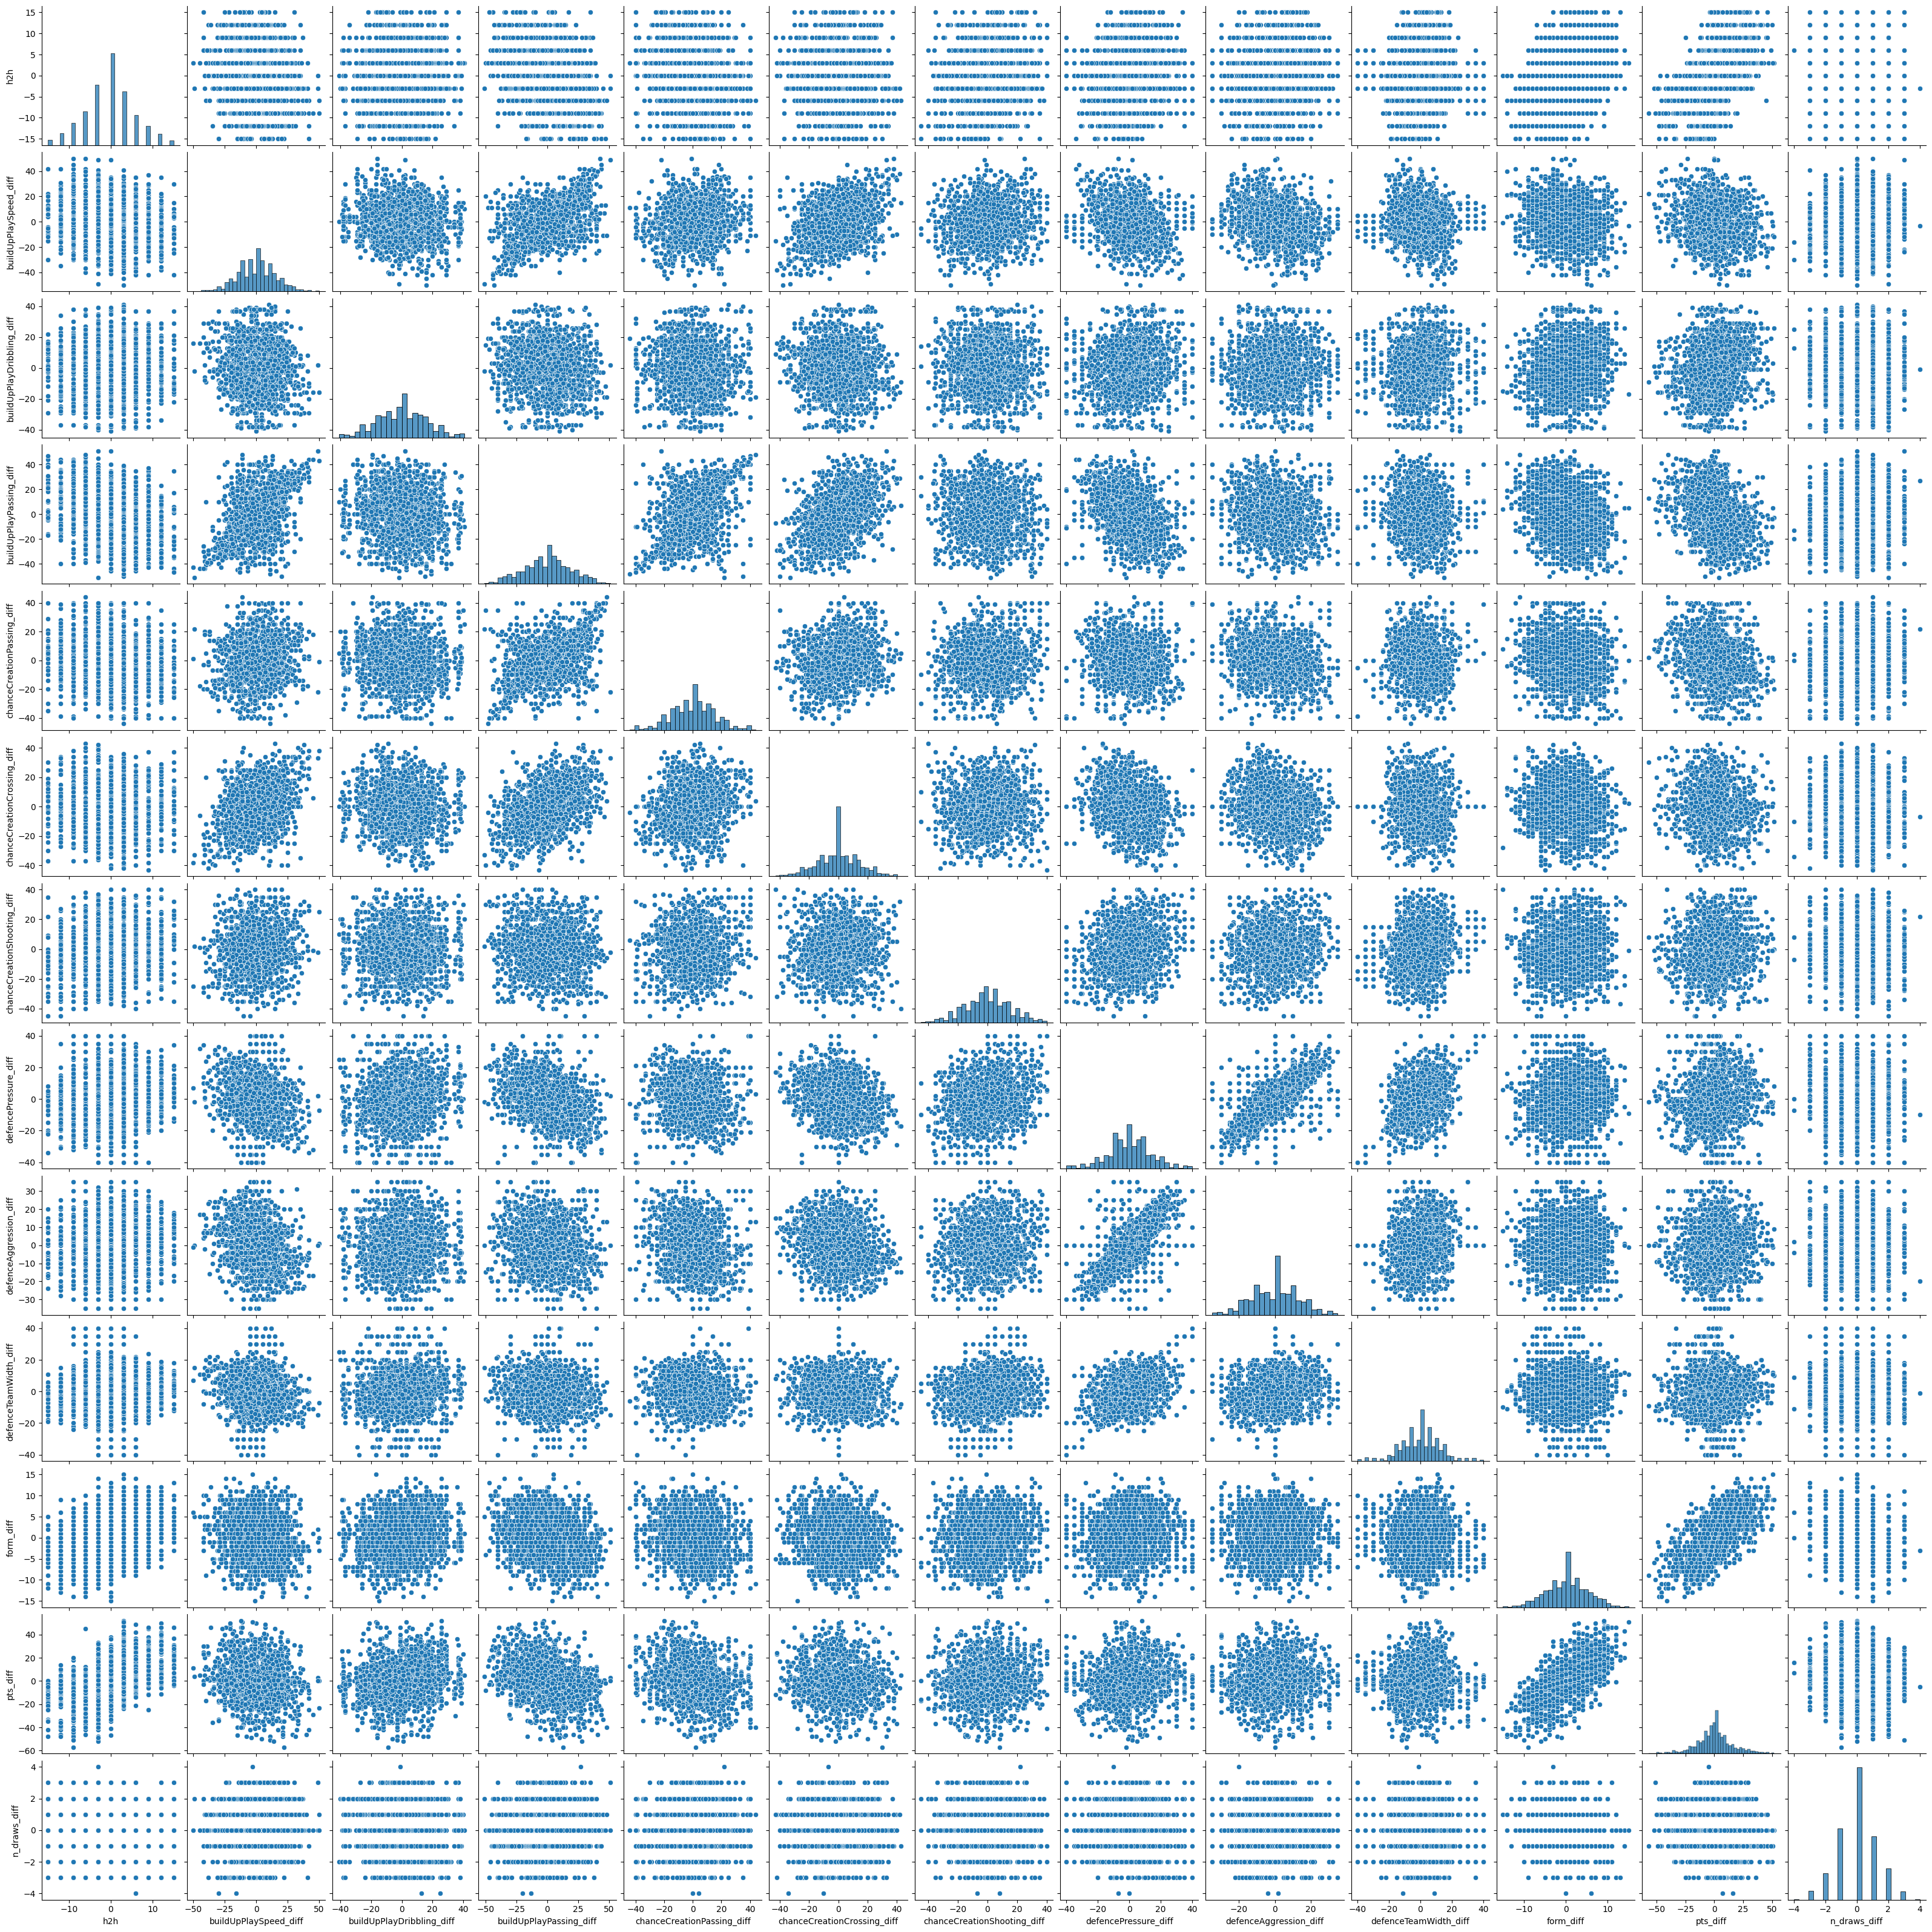

In [ ]:
sns.pairplot(asd)

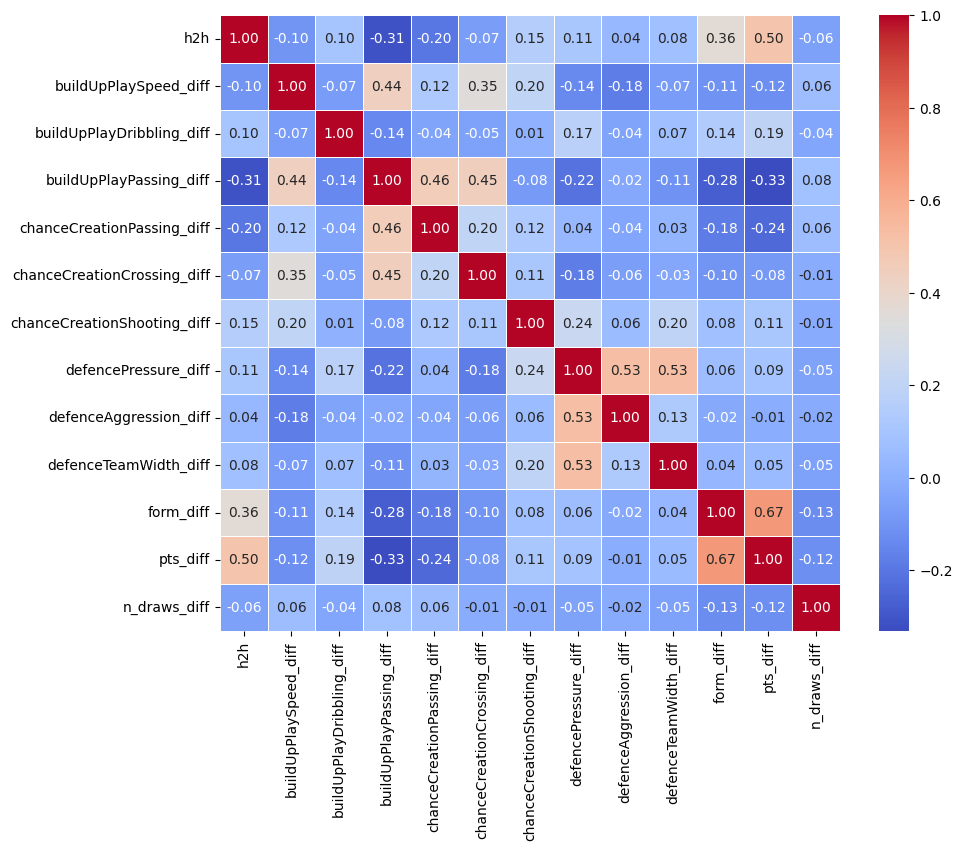

In [ ]:
corr_matrix = asd.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

Here we can make the deduction that all there features selected for training the model are uncorrelated and there are no redundencies.

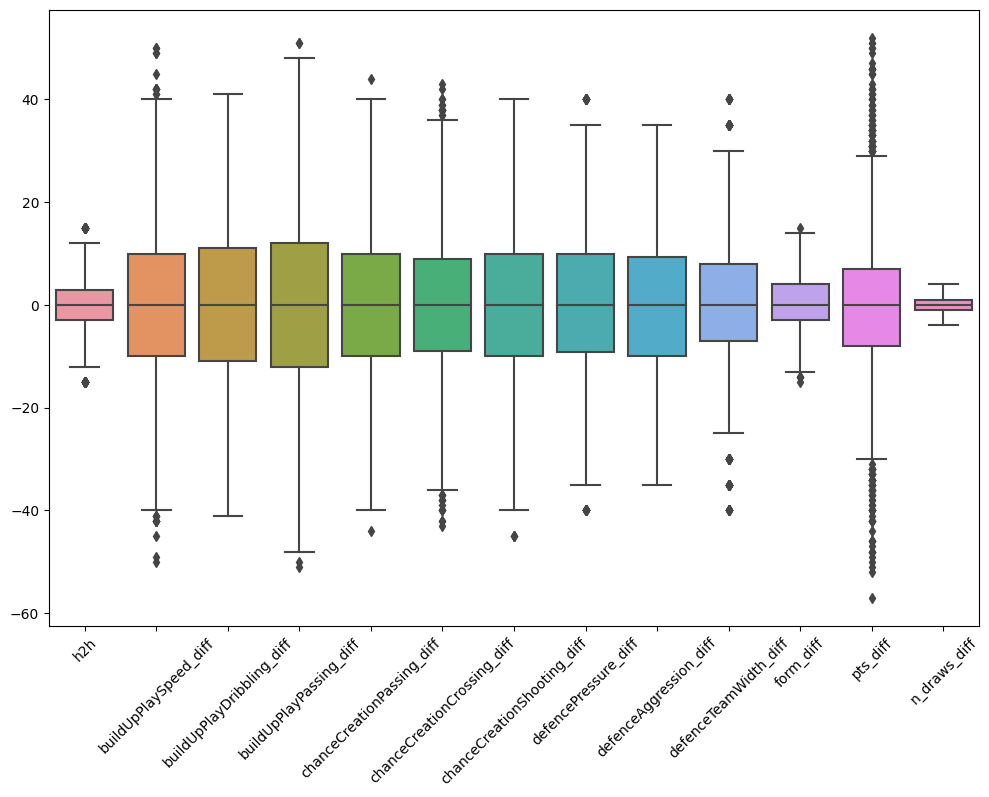

In [ ]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=asd)
plt.xticks(rotation=45)
plt.show()


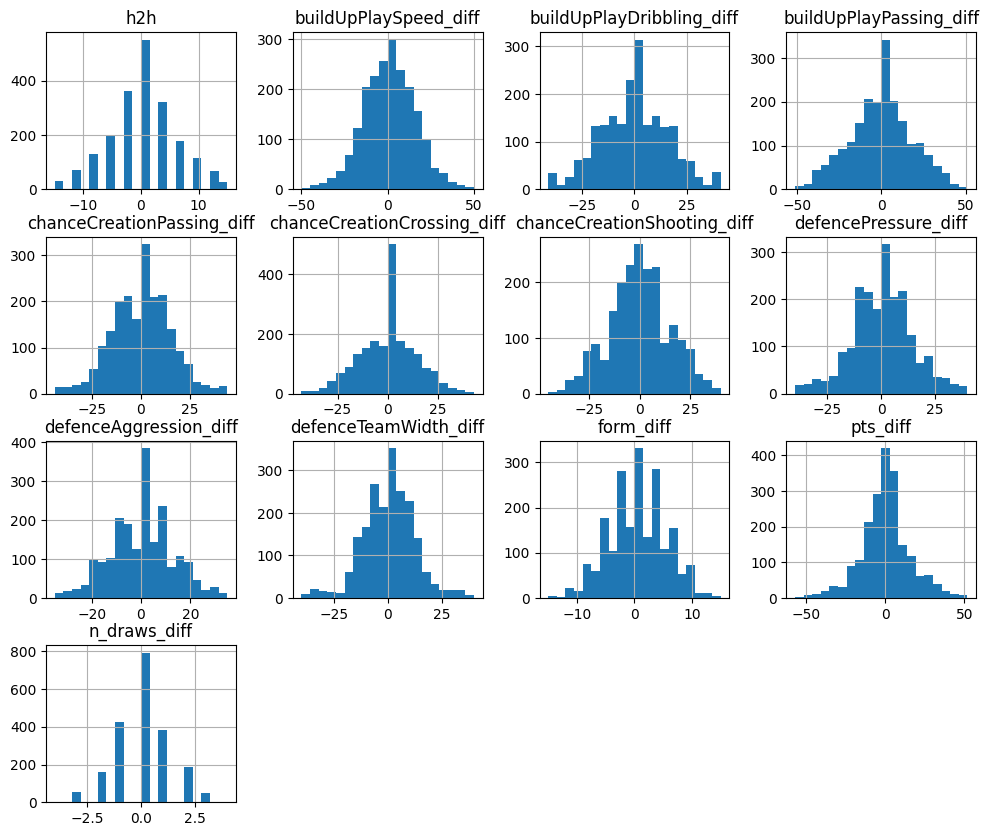

In [ ]:
asd.hist(figsize=(12, 10), bins=20)
plt.show()


All of the varibles have a normal distribution.

# Implementing Different Models

## SGD Classifier

Stochastic Gradient Descent (SGD) is an iterative optimization algorithm used for training machine learning models, particularly well-suited for large datasets. In the context of classification, the SGD classifier seeks to minimize the log loss function during training, adjusting model parameters to make predictions.

### Model Training and Testing

The dataset was split into training and testing sets. Train set was all avaiable match data excluding the 2014/2015 and 2015/2016 seasons whitch were used for testing. The model was trained using the Stochastic Gradient Descent (SGD) classifier with log loss, an alpha of 0.0001, and a maximum of 1000 iterations.

### Model Evaluation

The trained SGD classifier was evaluated on the test set using various classification metrics:

- **Accuracy:** The model achieved an accuracy of 55.71% on the test set.



In [ ]:
# Columns included in x_train
additional_columns = ['h2h','form_diff', 'n_draws_diff', 'pts_diff', 'match_importance']

# Combine the '_diff' columns and additional columns
columns_for_x_train = [f'{column}_diff' for column in columns_to_subtract] + additional_columns

# Create x_train DataFrame with selected columns
x = df_pl_full[columns_for_x_train].copy()

In [ ]:
print(x.columns)

Index(['buildUpPlaySpeed_diff', 'buildUpPlayDribbling_diff',
       'buildUpPlayPassing_diff', 'chanceCreationPassing_diff',
       'chanceCreationCrossing_diff', 'chanceCreationShooting_diff',
       'defencePressure_diff', 'defenceAggression_diff',
       'defenceTeamWidth_diff', 'h2h', 'form_diff', 'n_draws_diff', 'pts_diff',
       'match_importance'],
      dtype='object')


In [ ]:
y = df_pl_full[['result']]
y

result
644   Home Win
645   Home Win
646   Away Win
647   Home Win
648   Away Win
...        ...
2695  Away Win
2696      Draw
2697  Away Win
2698  Home Win
2699  Home Win

[2056 rows x 1 columns]

In [ ]:
# Filter data for training (excluding 2014/2015 and 2015/2016 seasons)
df_pl_full_train = df_pl_full[~df_pl_full['season'].isin(['2014/2015', '2015/2016'])]
df_pl_full_test = df_pl_full[df_pl_full['season'].isin(['2014/2015', '2015/2016'])]

x_train_s = df_pl_full_train[columns_for_x_train].copy()
y_train_s = df_pl_full_train['result'].copy()
x_test_s = df_pl_full_test[columns_for_x_train].copy()
y_test_s = df_pl_full_test['result'].copy()

softmax_sgd = SGDClassifier(loss='log_loss', alpha=0.0001, max_iter=1000, random_state=42)

softmax_sgd.fit(x_train_s, y_train_s)

y_pred_s = softmax_sgd.predict(x_test_s)

Accuracy: 0.5571428571428572
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.61      0.53      0.57       132
        Draw       0.25      0.20      0.22       107
    Home Win       0.65      0.79      0.71       181

    accuracy                           0.56       420
   macro avg       0.50      0.51      0.50       420
weighted avg       0.53      0.56      0.54       420



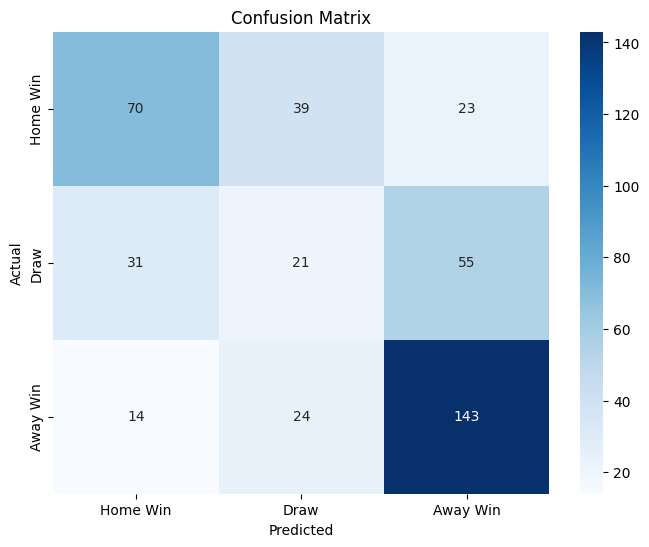

In [ ]:
# Example for classification metrics
accuracy_sgd = accuracy_score(y_test_s, y_pred_s)
report = classification_report(y_test_s, y_pred_s)
print(f'Accuracy: {accuracy_sgd}')
print(f'Classification Report:\n{report}')

# Confusion matrix with actual numbers
cm = confusion_matrix(y_test_s, y_pred_s)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Home Win', 'Draw', 'Away Win'], yticklabels=['Home Win', 'Draw', 'Away Win'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Random Forest Model
#### Model Overview

Random Forest is an ensemble learning algorithm that combines multiple decision trees to improve predictive accuracy. This model leverages information from the most recent season for classification.

#### Performance Metrics

- **Accuracy:** 64.52%
  *(Indicates the proportion of correctly classified instances.)*


In [ ]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.019, random_state=1)

# Assuming 'model' is your actual classifier
model = RandomForestClassifier()
model.fit(x_train, y_train)

<ipython-input-38-57ff224fe4b8>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


RandomForestClassifier()

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
accuracy_rf1 = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy_rf1}')
print(f'Classification Report:\n{report}')

Accuracy: 0.6
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.79      0.92      0.85        12
        Draw       0.43      0.21      0.29        14
    Home Win       0.53      0.71      0.61        14

    accuracy                           0.60        40
   macro avg       0.58      0.62      0.58        40
weighted avg       0.57      0.60      0.57        40



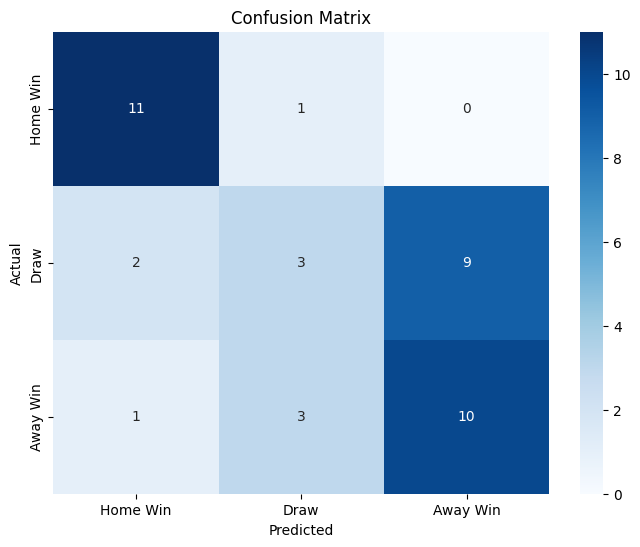

In [ ]:
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Home Win', 'Draw', 'Away Win'], yticklabels=['Home Win', 'Draw', 'Away Win'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
scores = cross_val_score(model, x_train, y_train, cv=5)  # Adjust the number of folds (cv) as needed
print(f'Cross-validated Accuracy: {np.mean(scores):.2f} (+/- {np.std(scores):.2f})')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed whe

Cross-validated Accuracy: 0.63 (+/- 0.01)


In [ ]:
y_test_pred = model.predict(x_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.2f}')

Test Accuracy: 0.60


Since in our data set we only have 40 matches, we decided to test with a larger set. So we went with last two seasons. By increasing the test size, we imporved our accuracy score. The first time, the test set was simply not big enough to judge the performance of the model (Test Size 0.019 signifing a split where there were only 40 games in the test set which is the number of games in the dataset for the final season).

Accuracy: 0.6452380952380953
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.67      0.70      0.68       132
        Draw       0.43      0.19      0.26       107
    Home Win       0.68      0.88      0.76       181

    accuracy                           0.65       420
   macro avg       0.59      0.59      0.57       420
weighted avg       0.61      0.65      0.61       420



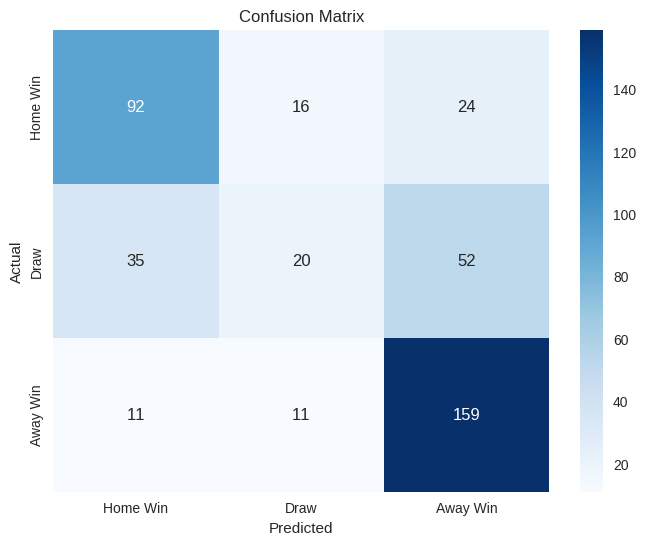

In [ ]:
# Filter data for training (excluding 2014/2015 and 2015/2016 seasons)
df_pl_full_train = df_pl_full[~df_pl_full['season'].isin(['2014/2015', '2015/2016'])]
df_pl_full_test = df_pl_full[df_pl_full['season'].isin(['2014/2015', '2015/2016'])]

# Define features and target variables
x_train = df_pl_full_train[columns_for_x_train].copy()
y_train = df_pl_full_train['result'].copy()
x_test = df_pl_full_test[columns_for_x_train].copy()
y_test = df_pl_full_test['result'].copy()

# Initialize and train the RandomForestClassifier
model = RandomForestClassifier()
model.fit(x_train, y_train)

# Predictions on the test set
y_pred = model.predict(x_test)

# Example for classification metrics
gb_accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f'Accuracy: {gb_accuracy}')
print(f'Classification Report:\n{report}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Home Win', 'Draw', 'Away Win'], yticklabels=['Home Win', 'Draw', 'Away Win'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


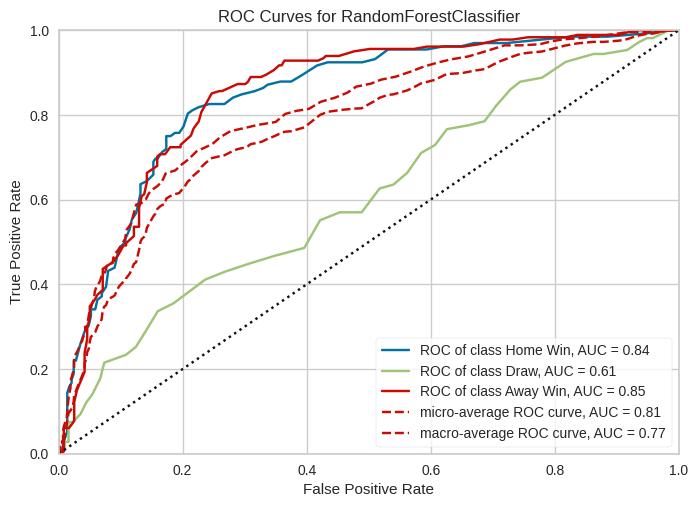

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
visualizer = ROCAUC(model, classes=['Home Win', 'Draw', 'Away Win'])
visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show()

Best Overall Performance.

## Gradient Boosting
Gradient Boosting is an ensemble learning technique that sequentially combines weak learners, often shallow decision trees, to improve predictive accuracy. It corrects errors made by previous models and is effective for capturing complex relationships in both regression and classification tasks.

### Model Training and Testing

The dataset was split into training and testing sets, and a Gradient Boosting Classifier was employed for the classification task. The classifier was configured with hyperparameters such as learning rate, number of estimators, and maximum depth to optimize its performance.

### Model Evaluation

The Gradient Boosting Classifier was evaluated on the test set using various classification metrics:

- **Accuracy:** The model achieved an accuracy of 64.29% on the test set.


In [ ]:
# Define features and target variables
x_train = df_pl_full_train[columns_for_x_train].copy()
y_train = df_pl_full_train['result'].copy()
x_test = df_pl_full_test[columns_for_x_train].copy()
y_test = df_pl_full_test['result'].copy()

gb_classifier = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=42)

# Training the model on the training data
gb_classifier.fit(x_train, y_train)

# Making predictions on the test data
y_pred = gb_classifier.predict(x_test)

# Accuracy and report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy:.2%}')
print(f'Classification Report:\n{report}')
print(f'Confusion Matrix:\n{cm}')

Accuracy: 64.29%
Classification Report:
              precision    recall  f1-score   support

    Away Win       0.66      0.67      0.66       132
        Draw       0.39      0.24      0.30       107
    Home Win       0.71      0.86      0.78       181

    accuracy                           0.64       420
   macro avg       0.59      0.59      0.58       420
weighted avg       0.61      0.64      0.62       420

Confusion Matrix:
[[ 88  25  19]
 [ 36  26  45]
 [ 10  15 156]]


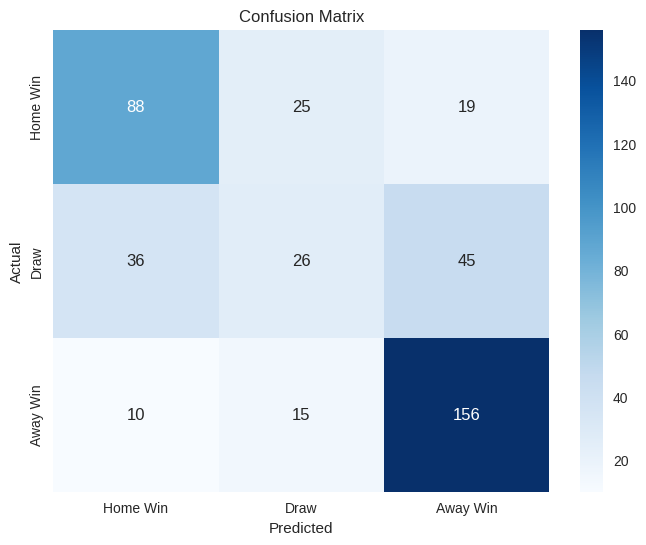

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Home Win', 'Draw', 'Away Win'], yticklabels=['Home Win', 'Draw', 'Away Win'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


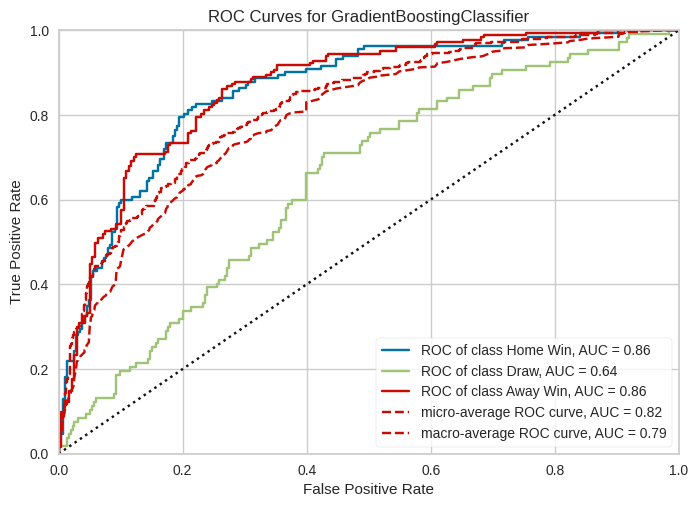

In [ ]:
visualizer = ROCAUC(gb_classifier, classes=['Home Win', 'Draw', 'Away Win'])

visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show()

plt.show()

Best Model with respect to predicting 'Draw's.

## Support Vector Machine (SVM) Model

### Model Overview

SVM is a powerful classification algorithm known for its effectiveness in capturing complex relationships in data. The model employs a radial basis function (RBF) kernel with parameters tuned for optimal performance.

### Performance Metrics

- **Accuracy:** 58.81%
  *(Indicates the proportion of correctly classified instances.)*
  This is the worst model so far regarding the draw predictions. It is almost touching the diagonal line indication random performance.

In [ ]:
# Define features and target variables
x_train = df_pl_full_train[columns_for_x_train].copy()
y_train = df_pl_full_train['result'].copy()
x_test = df_pl_full_test[columns_for_x_train].copy()
y_test = df_pl_full_test['result'].copy()

# Initializing the model
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier.fit(x_train, y_train)
y_pred_svm = svm_classifier.predict(x_test)

# Accuracy and report
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)
cm_svm = confusion_matrix(y_test, y_pred_svm)

print(f'SVM Accuracy: {accuracy_svm:.2%}')
print(f'SVM Classification Report:\n{report_svm}')

SVM Accuracy: 58.81%
SVM Classification Report:
              precision    recall  f1-score   support

    Away Win       0.61      0.62      0.62       132
        Draw       0.31      0.11      0.16       107
    Home Win       0.62      0.85      0.71       181

    accuracy                           0.59       420
   macro avg       0.51      0.53      0.50       420
weighted avg       0.54      0.59      0.54       420



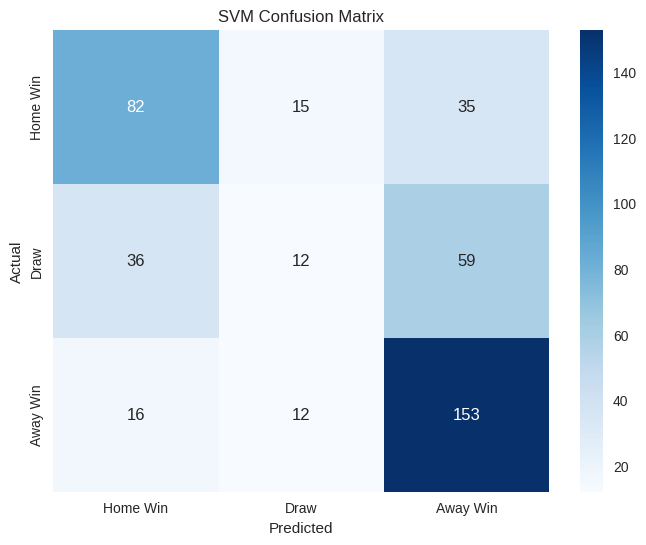

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Home Win', 'Draw', 'Away Win'], yticklabels=['Home Win', 'Draw', 'Away Win'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


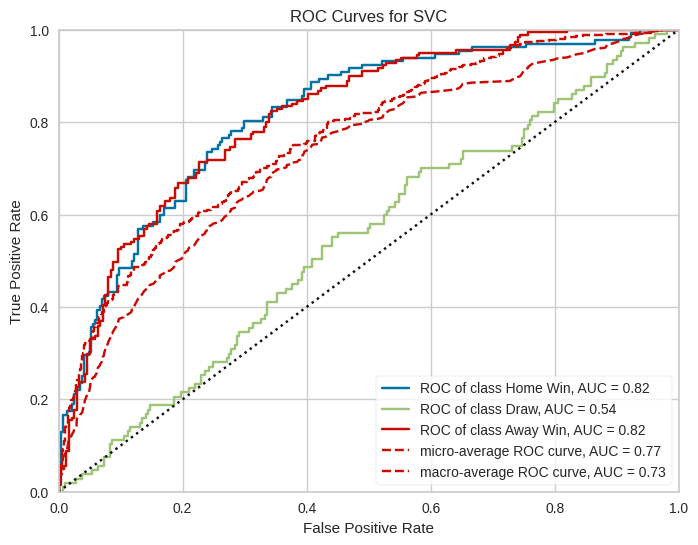

<Axes: title={'center': 'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
plt.figure(figsize=(8, 6))
visualizer = ROCAUC(svm_classifier, classes=['Home Win', 'Draw', 'Away Win'])
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show()

If we look at the green line, it show that the model has very poor perfermormance when it comes to predicting Draws.

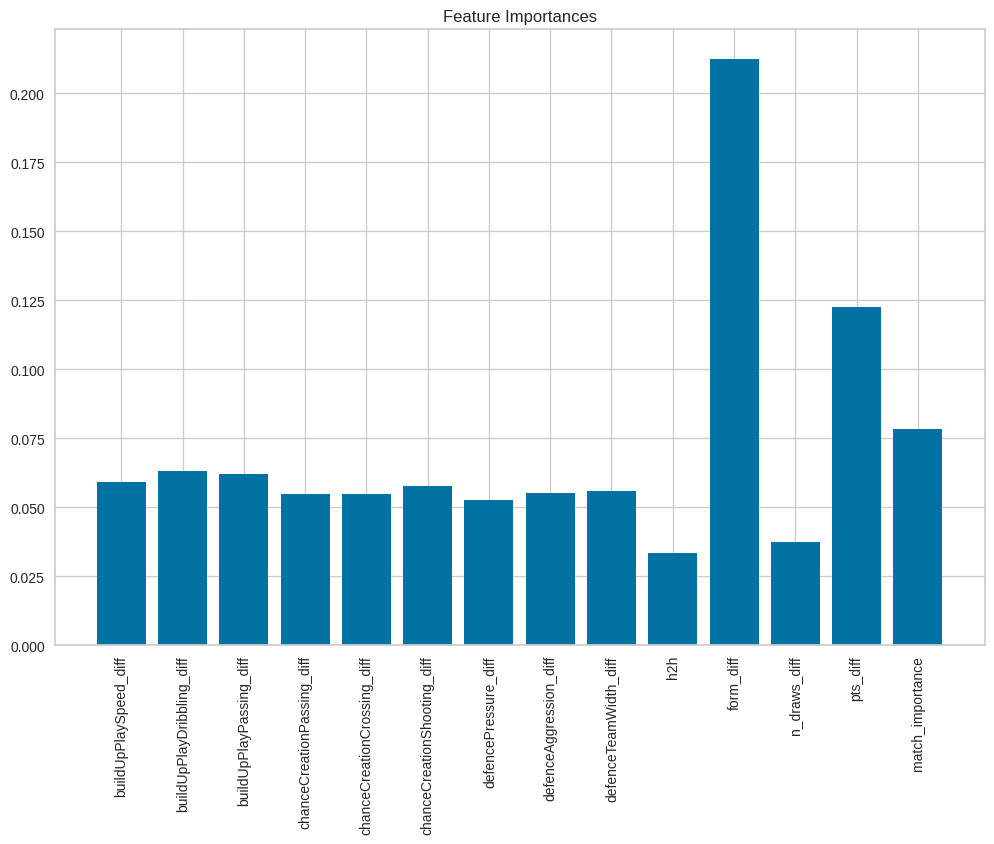

In [ ]:
importances = model.feature_importances_
feature_names = x_train.columns  # Adjust if your features are indexed differently

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(feature_names, importances)
plt.xticks(rotation='vertical')
plt.show()

# Model Comparison

Finally, we compare all the models we have created.

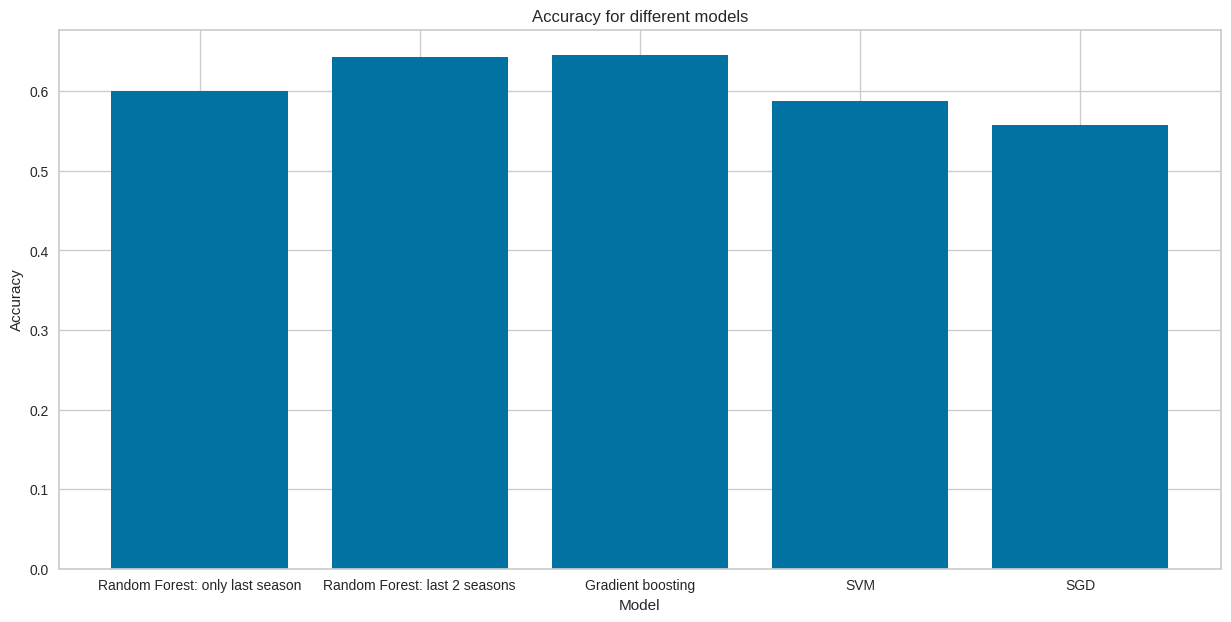

In [ ]:
accuracies = [accuracy_rf1, accuracy, gb_accuracy, accuracy_svm, accuracy_sgd]
plt.figure(figsize=(15, 7))
plt.bar(['Random Forest: only last season', 'Random Forest: last 2 seasons', 'Gradient boosting', 'SVM', 'SGD'], accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for different models')
plt.show()

# Conclusion
In summary, the Random Forest models performs best overall, especially when considering season-specific data. but Gradient Boosting also has very similar overall accuracy scores and it performs better when we condiser the "Draw"s. SVM also exhibit competitive accuracy, while the SGD Classifier shows moderate performance. The choice of the most suitable model may depend on specific considerations such as interpretability, training time, and the nature of the dataset. it is also notable that SVM may have better accuracy overall than SGD, but its performance when it comes to "Draw" is by far the worst. We could also look at the other metrics to get a better and broader view of the models. However, in general, all the models struggled with predicting "Draw". One thing to note also is that the task of predicting match results is incredibly difficult and even bookmakers who use state of the art models and expert knowledge do not achieve 80 or 90% accuracy on their models.